<a href="https://colab.research.google.com/github/virf96/Basico/blob/main/voting_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def metricas(model,Xv,yv): #Mide efectividad de un Modelo Predictivo
    print( " F1 Validate: %.3f" %f1_score(y_pred=model.predict(Xv),y_true=yv, average="weighted"))
    print( " Acc Validate: %.3f" %accuracy_score(y_pred=model.predict(Xv),y_true=yv))
    print( " Matrix Conf Validate: \n ", confusion_matrix(y_pred=model.predict(Xv),y_true=yv), end="\n\n")

In [4]:
data = pd.read_pickle("/content/drive/MyDrive/datasets/camiones_rendimiento.pkl")

In [5]:
data

,Fecha,Identificador de Camión,Consumo de combustible,Temperatura del Refrigerante,Factor de Carga,RPM,Velocidad
0,2020-04-03,84120100,1-2,95.0,36.0,1489.0,44.0
1,2020-10-07,84120100,1-2,96.0,41.0,1510.0,43.0
2,2020-12-18,84120100,.50-1,93.0,60.0,1487.0,NaN
3,2020-12-27,84120100,2-3,90.0,59.0,1459.0,39.0
4,2020-08-23,84120100,2-3,101.0,23.0,1566.0,48.0
...,...,...,...,...,...,...,...
99995,2020-11-29,99960100,1-2,98.0,49.0,1456.0,51.0
99996,2020-10-27,99960100,2-3,107.0,25.0,1529.0,60.0
99997,2020-12-03,99960100,.50-1,95.0,44.0,1415.0,52.0
99998,2020-11-18,99960100,.50-1,97.0,53.0,1332.0,36.0


In [6]:
data['Consumo de combustible'].value_counts(1)

.50-1    0.44761
2-3      0.24960
1-2      0.15060
0-.50    0.10069
+3       0.05150
Name: Consumo de combustible, dtype: float64

In [7]:
feats = ["Velocidad","RPM", "Factor de Carga",  "Temperatura del Refrigerante"]
tgt = "Consumo de combustible"

In [8]:
X = data[feats]
y = data[tgt]

In [9]:
lbl = LabelEncoder()
y = pd.Series(lbl.fit_transform(y),index=y.index)

In [10]:
y

0        3
1        3
2        1
3        4
4        4
        ..
99995    3
99996    4
99997    1
99998    1
99999    0
Length: 100000, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
y_train.value_counts(1)

1    0.449716
4    0.247970
3    0.150970
2    0.099925
0    0.051418
dtype: float64

In [13]:
y_test.value_counts(1)

1    0.443333
4    0.252909
3    0.149848
2    0.102242
0    0.051667
dtype: float64

In [15]:
#Definimos pasos para el pipeline
steps = [("impute",SimpleImputer(strategy="median")) , ("scaler",StandardScaler()),("pca",PCA(3)) ]

In [16]:
pipeline_preprocessing = Pipeline(steps=steps)
pipeline_preprocessing.fit(X_train,)

Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=3,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

In [17]:
X_train_transformed = pipeline_preprocessing.transform(X_train)
X_test_transformed = pipeline_preprocessing.transform(X_test)

In [25]:
pd.DataFrame(np.c_[X_train_transformed,y_train],columns = ["p1","p2","p3",tgt])

,p1,p2,p3,Consumo de combustible
0,-0.096817,-1.458799,-0.035095,1.0
1,-0.340184,0.763632,-0.799643,3.0
2,-1.211667,-0.477425,0.223122,1.0
3,0.189781,-1.328724,-1.142010,1.0
4,-0.261732,0.293766,-0.396505,1.0
...,...,...,...,...
66995,-0.007954,-1.635495,-1.469728,1.0
66996,-1.217916,-1.087783,0.305184,1.0
66997,0.558424,0.636208,-0.802715,3.0
66998,-0.954076,-1.751852,-0.855700,1.0


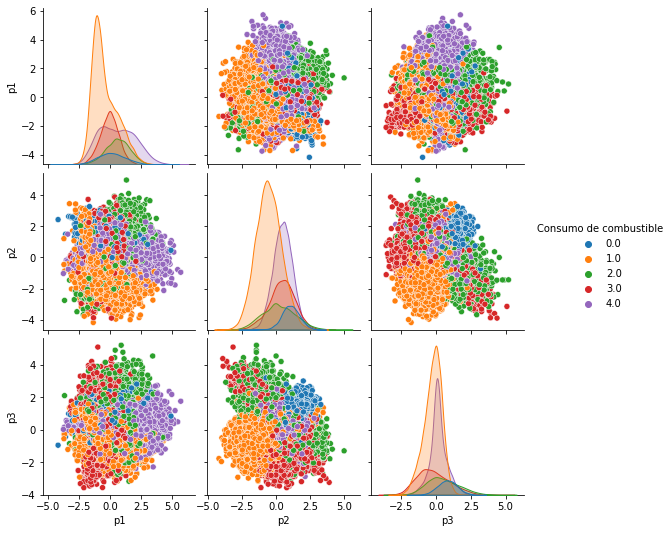

In [18]:
sns.pairplot(pd.DataFrame(np.c_[X_train_transformed,y_train],columns = ["p1","p2","p3",tgt]) , 
             hue=tgt, palette=sns.color_palette("tab10",n_colors=5))

In [19]:
models = [RandomForestClassifier(n_estimators=1000,max_depth = 1000), 
                      KNeighborsClassifier(15), MLPClassifier(hidden_layer_sizes=(100,50,100,50) ,learning_rate_init=.001) ]

In [20]:
model_results = []
for model in models:
    model_name = type(model).__name__
    print(f"Training {model_name}", end="\n\n")
    model.fit(X_train_transformed,y_train)
    
    metricas(model,X_test_transformed, y_test)
    
    model_results.append((model_name,model))
    
    print("Finish", end="\n\n\n")

Training RandomForestClassifier

 F1 Validate: 0.708
 Acc Validate: 0.717
 Matrix Conf Validate: 
  [[  883   162    83   118   459]
 [   47 13204   132   444   803]
 [  118   524  1076   681   975]
 [  136   794   450  2659   906]
 [  181  1111   460   743  5851]]

Finish


Training KNeighborsClassifier

 F1 Validate: 0.715
 Acc Validate: 0.725
 Matrix Conf Validate: 
  [[  891   172    67   112   463]
 [   36 13394   113   384   703]
 [  138   548  1104   643   941]
 [  139   833   461  2689   823]
 [  185  1163   431   710  5857]]

Finish


Training MLPClassifier



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


 F1 Validate: 0.724
 Acc Validate: 0.737
 Matrix Conf Validate: 
  [[  862   164    48    86   545]
 [   36 13501    87   345   661]
 [   95   540  1110   590  1039]
 [  104   858   393  2636   954]
 [  100  1196   254   588  6208]]

Finish




In [26]:
voting_model = VotingClassifier(estimators=model_results, voting='hard')
voting_model = voting_model.fit(X_train_transformed,  y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
metricas(voting_model,  X_train_transformed, y_train)

 F1 Validate: 0.827
 Acc Validate: 0.832
 Matrix Conf Validate: 
  [[ 2587   246    26    69   517]
 [  126 28816    65   348   776]
 [  285  1033  3803   592   982]
 [  287  1448   632  6894   854]
 [  209  1700   416   623 13666]]



In [ ]:
metricas(voting_model,  X_test_transformed, y_test)

 F1 Validate: 0.814
 Acc Validate: 0.825
 Matrix Conf Validate: 
  [[  926   161    61    88   469]
 [   48 13379    95   377   731]
 [  139   561  1119   613   942]
 [  166   850   473  2596   860]
 [  214  1183   433   616  5900]]
